## Astrometry catalog

Process an association and derive an astrometric catalog to send to the `astrometry_db` database.

For fields that don't have a good existing astrometric reference (i.e., the pointings *not* in COSMOS, GOODS), derive a catalog from one JWST filter, e.g., F444W, and then align all other JWST filters to that one.

In [1]:
import os
if os.getenv('CRDS_PATH') is None:
    print('Set environment variables....')
    
    os.environ['CRDS_PATH'] = '/tmp/crds_cache'
    os.environ['CRDS_SERVER_URL'] = "https://jwst-crds.stsci.edu"

if os.getenv('iref') is None:
    os.environ['iref'] = '/tmp/crds_cache/iref'
    
if os.getenv('jref') is None:
    os.environ['jref'] = '/tmp/crds_cache/jref'

if os.path.exists('/workspaces/panoramic-jwst/Astrometry'):
    os.chdir('/workspaces/panoramic-jwst/Astrometry')

if os.path.exists('../LocalWorkspace'):
    os.chdir('../LocalWorkspace')

import glob

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from grizli import utils, prep
from grizli.aws import db, visit_processor

import jwst
print('jwst', jwst.__version__)

import grizli
print('grizli', grizli.__version__)


`import jwst` failed so JWST processing will not work!
Set ROOT_PATH=/workspaces/panoramic-jwst/Astrometry
jwst 1.10.2
grizli 1.8.11


In [2]:
# Find PANORAMIC visits that haven't been processed

progs = "'2514'" # PANORAMIC
# progs = "'4445','4446'" # DD programs
# progs = "'1837'" # PRIMER

filter = 'F444W-CLEAR'

if 0:
    # CANUCS 1149 cluster
    progs = "'1208'" # PRIMER
    filter = 'F410M-CLEAR'


panoramic_assoc = db.SQL(f"""select assoc_name, max(status) as status, max(filter) as filter
from assoc_table
where status != 2 and filter in ('{filter}')
and proposal_id in ({progs})
GROUP BY assoc_name
"""
) 
# comment
assoc_list = panoramic_assoc['assoc_name']
panoramic_assoc

assoc_name,status,filter
str36,int64,str11
j131432p2432_indef-f115w-f444w_00004,0,F444W-CLEAR
j131432p2432_indef-f277w-f444w_00009,0,F444W-CLEAR
j134348p5549_indef-f200w-f444w_00028,0,F444W-CLEAR
j134348p5549_indef-f200w-f444w_00029,0,F444W-CLEAR


In [5]:

# assoc_list = ['j100736p2109_indef-f444w_00023']

for assoc in assoc_list:
    print(assoc)
    
    if True:
        visit_processor.process_visit(assoc, sync=False, clean=False)


j131432p2432_indef-f115w-f444w_00004
# (2023-06-12 20:59:02.801)
# get_wcs_guess : No entries found in wcs_log for wcs_assoc='j131432p2432_indef-f115w-f444w_00004'
Fetch params from s3://grizli-v2/HST/Pipeline/Input/j131432p2432_indef-f115w-f444w_00004.yaml

# Write parameters to j131432p2432_indef-f115w-f444w_00004.run.yaml

Failed to `import dust_attenuation`
Install my fork with $ pip install git+https://github.com/gbrammer/dust_attenuation.git
Failed to `import dust_extinction`
Install my fork with $ pip install git+https://github.com/gbrammer/dust_extinction.git
j131432p2432_indef-f115w-f444w_00004 : found 5 GAIA sources
j131432p2432_indef-f115w-f444w_00004.gaia.reg: x = ra, y=dec, ellipse=False
# (2023-06-12 20:59:06.924)

auto_script.fetch_files(**{'field_root': 'j131432p2432_indef-f115w-f444w_00004', 'HOME_PATH': '$PWD', 'paths': {'home': '/workspaces/panoramic-jwst/Astrometry', 'base': '/workspaces/panoramic-jwst/Astrometry/j131432p2432_indef-f115w-f444w_00004', 'raw': '/works

cp: cannot stat '*mask.reg': No such file or directory


** Combine Singles: **
0 indef-02514-209-124.0-nrcb5-f444w-clear 4

 == Grism groups ==

# (2023-06-12 20:59:08.628)

auto_script.preprocess(**{'field_root': 'j131432p2432_indef-f115w-f444w_00004', 'HOME_PATH': '/workspaces/panoramic-jwst/Astrometry', 'PERSIST_PATH': '/workspaces/panoramic-jwst/Astrometry/j131432p2432_indef-f115w-f444w_00004/Persistence', 'min_overlap': 0.2, 'make_combined': False, 'catalogs': ['PS1', 'DES', 'NSC', 'SDSS', 'GAIA', 'WISE'], 'use_visit': True, 'master_radec': 'astrometry_db', 'parent_radec': None, 'use_first_radec': False, 'skip_imaging': False, 'clean': True, 'skip_single_optical_visits': False, 'visit_prep_args': {'align_thresh': None, 'align_rms_limit': 2, 'align_mag_limits': [14, 26.5, 0.1], 'align_assume_close': False, 'align_transform': None, 'align_ref_border': 100, 'align_guess': None, 'max_err_percentile': 99, 'align_min_flux_radius': 1.0, 'catalog_mask_pad': 0.05, 'match_catalog_density': False, 'skymethod': 'localmin', 'drizzle_params': {}, 's

cp: cannot stat '*mask.reg': No such file or directory


** Combine Singles: **
0 indef-02514-209-124.0-nrca5-f444w-clear 4

 == Grism groups ==

# (2023-06-12 20:59:13.537)

auto_script.preprocess(**{'field_root': 'j131432p2432_indef-f277w-f444w_00009', 'HOME_PATH': '/workspaces/panoramic-jwst/Astrometry', 'PERSIST_PATH': '/workspaces/panoramic-jwst/Astrometry/j131432p2432_indef-f277w-f444w_00009/Persistence', 'min_overlap': 0.2, 'make_combined': False, 'catalogs': ['PS1', 'DES', 'NSC', 'SDSS', 'GAIA', 'WISE'], 'use_visit': True, 'master_radec': 'astrometry_db', 'parent_radec': None, 'use_first_radec': False, 'skip_imaging': False, 'clean': True, 'skip_single_optical_visits': False, 'visit_prep_args': {'align_thresh': None, 'align_rms_limit': 2, 'align_mag_limits': [14, 26.5, 0.1], 'align_assume_close': False, 'align_transform': None, 'align_ref_border': 100, 'align_guess': None, 'max_err_percentile': 99, 'align_min_flux_radius': 1.0, 'catalog_mask_pad': 0.05, 'match_catalog_density': False, 'skymethod': 'localmin', 'drizzle_params': {}, 's

cp: cannot stat '*mask.reg': No such file or directory


** Combine Singles: **
0 indef-02514-055-134.0-nrcb5-f444w-clear 4

 == Grism groups ==

# (2023-06-12 20:59:19.188)

auto_script.preprocess(**{'field_root': 'j134348p5549_indef-f200w-f444w_00028', 'HOME_PATH': '/workspaces/panoramic-jwst/Astrometry', 'PERSIST_PATH': '/workspaces/panoramic-jwst/Astrometry/j134348p5549_indef-f200w-f444w_00028/Persistence', 'min_overlap': 0.2, 'make_combined': False, 'catalogs': ['PS1', 'DES', 'NSC', 'SDSS', 'GAIA', 'WISE'], 'use_visit': True, 'master_radec': 'astrometry_db', 'parent_radec': None, 'use_first_radec': False, 'skip_imaging': False, 'clean': True, 'skip_single_optical_visits': False, 'visit_prep_args': {'align_thresh': None, 'align_rms_limit': 2, 'align_mag_limits': [14, 26.5, 0.1], 'align_assume_close': False, 'align_transform': None, 'align_ref_border': 100, 'align_guess': None, 'max_err_percentile': 99, 'align_min_flux_radius': 1.0, 'catalog_mask_pad': 0.05, 'match_catalog_density': False, 'skymethod': 'localmin', 'drizzle_params': {}, 's

cp: cannot stat '*mask.reg': No such file or directory


** Combine Singles: **
0 indef-02514-055-134.0-nrca5-f444w-clear 4

 == Grism groups ==

# (2023-06-12 20:59:24.096)

auto_script.preprocess(**{'field_root': 'j134348p5549_indef-f200w-f444w_00029', 'HOME_PATH': '/workspaces/panoramic-jwst/Astrometry', 'PERSIST_PATH': '/workspaces/panoramic-jwst/Astrometry/j134348p5549_indef-f200w-f444w_00029/Persistence', 'min_overlap': 0.2, 'make_combined': False, 'catalogs': ['PS1', 'DES', 'NSC', 'SDSS', 'GAIA', 'WISE'], 'use_visit': True, 'master_radec': 'astrometry_db', 'parent_radec': None, 'use_first_radec': False, 'skip_imaging': False, 'clean': True, 'skip_single_optical_visits': False, 'visit_prep_args': {'align_thresh': None, 'align_rms_limit': 2, 'align_mag_limits': [14, 26.5, 0.1], 'align_assume_close': False, 'align_transform': None, 'align_ref_border': 100, 'align_guess': None, 'max_err_percentile': 99, 'align_min_flux_radius': 1.0, 'catalog_mask_pad': 0.05, 'match_catalog_density': False, 'skymethod': 'localmin', 'drizzle_params': {}, 's

In [6]:
# Check WCS log
! cat j*/Prep/*shifts.log

# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['jw02514209001_02201_00001_nrcblong_rate.fits'] = []
# match['jw02514209001_02201_00002_nrcblong_rate.fits'] = []
# match['jw02514209001_02201_00003_nrcblong_rate.fits'] = []
# match['jw02514209001_02201_00004_nrcblong_rate.fits'] = []
jw02514209001_02201_00001_nrcblong_rate.fits   0.000  -0.000  0.00000  1.00000   100  0.000  0.000
jw02514209001_02201_00002_nrcblong_rate.fits  -0.953  -1.894  0.00000  1.00000    93  0.047  0.048
jw02514209001_02201_00003_nrcblong_rate.fits   0.980  -2.374  0.00000  1.00000    97  0.043  0.039
jw02514209001_02201_00004_nrcblong_rate.fits   0.421  -1.047  0.00000  1.00000    94  0.049  0.044
# flt xshift yshift rot scale N rmsx rmsy
# fit_order: -1
# match['jw02514209001_02201_00001_nrcalong_rate.fits'] = []
# match['jw02514209001_02201_00002_nrcalong_rate.fits'] = []
# match['jw02514209001_02201_00003_nrcalong_rate.fits'] = []
# match['jw02514209001_02201_00004_nrcalong_rate.fits'] = []


## Make astrometric reference catalogs

In [7]:
! ls j*/Prep/*wcs.log

j131432p2432_indef-f115w-f444w_00004/Prep/indef-02514-209-124.0-nrcb5-f444w-clear_wcs.log
j131432p2432_indef-f277w-f444w_00009/Prep/indef-02514-209-124.0-nrca5-f444w-clear_wcs.log
j134348p5549_indef-f200w-f444w_00028/Prep/indef-02514-055-134.0-nrcb5-f444w-clear_wcs.log
j134348p5549_indef-f200w-f444w_00029/Prep/indef-02514-055-134.0-nrca5-f444w-clear_wcs.log


In [3]:
! cat j*/Prep/*wcs.log

# ext xshift yshift rot scale rms N
# radec: indef-02514-209-124.0-nrcb5-f444w-clear_ls_dr9.radec
# indef-02514-209-124.0-nrcb5-f444w-clear
    0       -0.4828        2.0927       -0.0164       1.00000         0.341   19
# ext xshift yshift rot scale rms N
# radec: indef-02514-209-124.0-nrca5-f444w-clear_ls_dr9.radec
# indef-02514-209-124.0-nrca5-f444w-clear
    0       -0.8560        2.0599       -0.0203       1.00000         0.626    9
# ext xshift yshift rot scale rms N
# radec: indef-02514-055-134.0-nrcb5-f444w-clear_ls_dr9.radec
# indef-02514-055-134.0-nrcb5-f444w-clear
    0        0.1558        0.5978        0.0335       1.00000         0.552    5
# ext xshift yshift rot scale rms N
# radec: indef-02514-055-134.0-nrca5-f444w-clear_ls_dr9.radec
# indef-02514-055-134.0-nrca5-f444w-clear
    0       -0.1091       -0.5164        0.0180       1.00000         0.757   13


In [4]:
ref_cats = db.SQL("""select src, count(src) 
from astrometry_reference
group by src
""")

HOME = os.getcwd()

REDO_REF_CATS = ['cos_primer_hst160_17_24']

def get_used_radec(file):
    """
    Get the radec catalog that was used to compare to those already in the database
    """
    with open(file.replace('.cat.fits', '_wcs.log')) as fp:
        line = fp.readlines()[1]
    
    return line.strip().split()[-1].replace('.radec','')

# Process reference catalogs

Flip `SEND_TO_DB=True` to actually send the catalogs to the `astrometry_reference` table in teh database.



Add 578 objects to astrometry_reference for j131432p2432_indef-f115w-f444w_00004/indef-02514-209-124.0-nrcb5-f444w-clear.cat.fits src=j131432p2432_f115w-f444w_00004_cat

/workspaces/panoramic-jwst/Astrometry/j131432p2432_f115w-f444w_00004_cat.reg: x = ra, y=dec, ellipse=False

! Set SEND_TO_DB=True to send the table to the remote DB

Add 447 objects to astrometry_reference for j131432p2432_indef-f277w-f444w_00009/indef-02514-209-124.0-nrca5-f444w-clear.cat.fits src=j131432p2432_f277w-f444w_00009_cat

/workspaces/panoramic-jwst/Astrometry/j131432p2432_f277w-f444w_00009_cat.reg: x = ra, y=dec, ellipse=False

! Set SEND_TO_DB=True to send the table to the remote DB

Add 477 objects to astrometry_reference for j134348p5549_indef-f200w-f444w_00028/indef-02514-055-134.0-nrcb5-f444w-clear.cat.fits src=j134348p5549_f200w-f444w_00028_cat

/workspaces/panoramic-jwst/Astrometry/j134348p5549_f200w-f444w_00028_cat.reg: x = ra, y=dec, ellipse=False

! Set SEND_TO_DB=True to send the table to the re

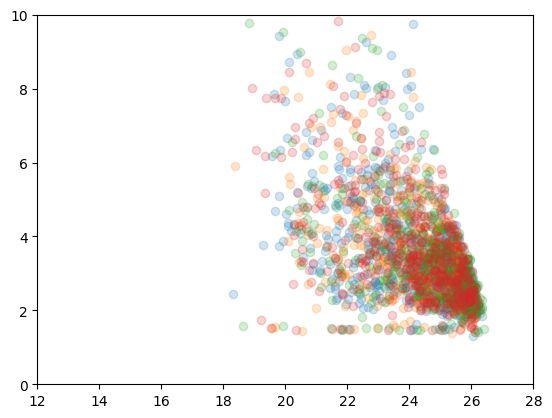

In [5]:
# Set to True to actually send the catalogs to the database table
SEND_TO_DB = False 

mag_lim = (17, 26)
flux_radius = (1,10)
sn = 20

max_count = 1000

for assoc in assoc_list:
    os.chdir(HOME)
    
    if os.path.exists(f'{assoc}/Prep'):
        os.chdir(f'{assoc}/Prep')
        files = glob.glob('*cat.fits')
        for file in files:
            ref_src = get_used_radec(file)
            if (ref_src in ref_cats['src']) & (ref_src not in REDO_REF_CATS):
                print(f'\n{file}: {ref_src} in astrometry_db\n')
                continue

            tab = utils.read_catalog(file)
            for c in list(tab.colnames):
                tab.rename_column(c, c.lower())

            tab['mag'] = tab['mag_auto']
            if True:
                #clip = tab['mag'] < mag_lim[1]
                clip = tab['mag'] > mag_lim[0]
                clip &= tab['mask_aper_1'] == 0
                clip &= tab['flux_radius'] > flux_radius[0]
                clip &= tab['flux_radius'] < flux_radius[1]
                clip &= tab['flux_aper_1'] / tab['fluxerr_aper_1'] > sn
                
                tab = tab[clip]
                so = np.argsort(tab['mag'])
                tab = tab[so]
                
                if max_count > 0:
                    tab = tab[:max_count]
                    
            plt.scatter(tab['mag_auto'], tab['flux_radius'], alpha=0.2)
            plt.ylim(0, 10)
            plt.xlim(12,28)
            
            if len(files) == 1:
                src = assoc+'_cat'
            else:
                src = os.path.basename(file).split('.cat')[0]
            
            src = src.replace('indef-','')
            
            tab['src'] = src
            try:
                ok = np.isfinite(tab['mag'].filled(np.nan))
                tab = tab[ok]
            except:
                pass

            print(f'\nAdd {len(tab)} objects to astrometry_reference for {assoc}/{file} src={src}\n')
            
            prep.table_to_regions(tab, os.path.join(HOME, f'{src}.reg'))
            
            # Set this to True to actually send the table!                
            if SEND_TO_DB:
                print(f'clean {src}')
                db.execute(f"delete from astrometry_reference where src='{src}'")
                print(f'upload {src}')
                db.send_to_database('astrometry_reference', tab['ra','dec','src','mag'], if_exists='append')
            else:
                print("\n! Set SEND_TO_DB=True to send the table to the remote DB")

os.chdir(HOME)

# Break here in Run All

In [1]:
print(breakme)

NameError: name 'breakme' is not defined

In [9]:
db.SQL("""select src, count(src) from astrometry_reference
where src like 'j1343%%' OR src like 'j1314%%'
group by src
""")

src,count
str34,int64
j131432p2432_f115w-f444w_00004_cat,578
j131432p2432_f277w-f444w_00009_cat,447
j134348p5549_f200w-f444w_00028_cat,477
j134348p5549_f200w-f444w_00029_cat,515


In [44]:
import time

with open('astrometry_log.txt','a') as fp:
    for assoc in assoc_list:
        fp.write(f'{assoc}   {time.ctime()}\n')


## Reset status and launch EC2

Now that the astrometry reference is in place, update the status of the unprocessed visits to zero and launch the processing on EC2

In [11]:
assoc_list = db.SQL(f"""select assoc_name, max(status) as status, max(filter) as filter
from assoc_table
where status != 2
and proposal_id in ({progs}) AND instrument_name in ('NIRCAM','NIRISS')
GROUP BY assoc_name
order by filter
"""
) 
assoc_list

assoc_name,status,filter
str36,int64,str11
j134348p5549_indef-f115w_00002,0,F115W-CLEAR
j134348p5549_indef-f115w_00003,0,F115W-CLEAR
j134348p5549_indef-f115w_00005,0,F115W-CLEAR
j134348p5549_indef-f115w_00007,0,F115W-CLEAR
j134348p5549_indef-f115w_00008,0,F115W-CLEAR
j134348p5549_indef-f115w-f444w_00004,0,F115W-CLEAR
j131432p2432_indef-f115w_00001,0,F115W-CLEAR
j131432p2432_indef-f115w_00002,0,F115W-CLEAR
j131432p2432_indef-f115w_00003,0,F115W-CLEAR


In [12]:
if len(assoc_list) > 0:
    db.execute(f"""update assoc_table set status = 0
where status != 2
and proposal_id in ({progs}) AND instrument_name in ('NIRCAM','NIRISS')
""") 

In [13]:
assoc_list = db.SQL(f"""select assoc_name, max(status) as status, max(filter) as filter
from assoc_table
where status != 2
and proposal_id in ({progs}) AND instrument_name in ('NIRCAM','NIRISS')
GROUP BY assoc_name
"""
) 
assoc_list

assoc_name,status,filter
str36,int64,str11
j131432p2432_indef-f115w_00000,0,F115W-CLEAR
j131432p2432_indef-f115w_00001,0,F115W-CLEAR
j131432p2432_indef-f115w_00002,0,F115W-CLEAR
j131432p2432_indef-f115w_00003,0,F115W-CLEAR
j131432p2432_indef-f115w_00005,0,F115W-CLEAR
j131432p2432_indef-f115w_00007,0,F115W-CLEAR
j131432p2432_indef-f115w_00008,0,F115W-CLEAR
j131432p2432_indef-f115w-f277w_00006,0,F115W-CLEAR
j131432p2432_indef-f115w-f444w_00004,0,F444W-CLEAR


In [14]:
# Pipeline parameters

import os
import yaml

# Aggressive 1/f correction for blank fields
defaults = {'visit_prep_args': {
                'oneoverf_kwargs': {'deg_pix':2048, 'dilate_iterations':3, 'thresholds':[5,4,3]},
                'align_mag_limits': [14, 26.5, 0.1],
            }, 
           }

if not os.path.exists('/tmp/pipeline_defaults'):
    os.mkdir('/tmp/pipeline_defaults')
    
if 1:
    ! rm /tmp/pipeline_defaults/*
    
for assoc in assoc_list['assoc_name']:
    # COSMOS-Web
    if assoc.split()[0] in ('j095944p0222','j100032p0216','j100028p0217'):
        if ('f770w' in assoc) | ('f1800w' in assoc):
            # MIRI
            defaults['global_miri_skyflat'] = True
            defaults['visit_prep_args']['oneoverf_kwargs'] = None
        else:
            # NIRCam
            defaults['visit_prep_args']['oneoverf_kwargs'] =  {'deg_pix':2048, 'dilate_iterations':3,
                                                               'thresholds':[5,4,3], 'other_axis':True}
            defaults['global_miri_skyflat'] = False
            
    else:
        has_grism = ('gr150' in assoc) | ('grism' in assoc)
        
        defaults['visit_prep_args']['oneoverf_kwargs'] =  {'deg_pix':2048, 'dilate_iterations':3, 
                                                           'thresholds':[5,4,3],
                                                           'other_axis':(not has_grism),
                                                          }
    
    with open(f'/tmp/pipeline_defaults/{assoc}.yaml','w') as fp:
        yaml.dump(defaults, fp)
       
if 1:
    ! aws s3 sync /tmp/pipeline_defaults/ s3://grizli-v2/HST/Pipeline/Input/ --acl public-read --exclude "*" --include "*yaml"

rm: cannot remove '/tmp/pipeline_defaults/*': No such file or directory
upload: ../../../tmp/pipeline_defaults/j131432p2432_indef-f115w-f444w_00004.yaml to s3://grizli-v2/HST/Pipeline/Input/j131432p2432_indef-f115w-f444w_00004.yaml
upload: ../../../tmp/pipeline_defaults/j131432p2432_indef-f150w-f356w_00014.yaml to s3://grizli-v2/HST/Pipeline/Input/j131432p2432_indef-f150w-f356w_00014.yaml
upload: ../../../tmp/pipeline_defaults/j131432p2432_indef-f115w_00002.yaml to s3://grizli-v2/HST/Pipeline/Input/j131432p2432_indef-f115w_00002.yaml
upload: ../../../tmp/pipeline_defaults/j131432p2432_indef-f115w-f277w_00006.yaml to s3://grizli-v2/HST/Pipeline/Input/j131432p2432_indef-f115w-f277w_00006.yaml
upload: ../../../tmp/pipeline_defaults/j131432p2432_indef-f150w-f356w_00011.yaml to s3://grizli-v2/HST/Pipeline/Input/j131432p2432_indef-f150w-f356w_00011.yaml
upload: ../../../tmp/pipeline_defaults/j131432p2432_indef-f115w_00001.yaml to s3://grizli-v2/HST/Pipeline/Input/j131432p2432_indef-f115w_000

## Launch EC2 instances

Flip the switch `if 0:` > `if 1` below to run up to 70 EC2 instances that will work through the preprocessing pipeline on all associations with `status=0` in the database.  The script below will launch `Ni = min(Ns//2, nmax)` instances where `Ns` is the number of `status=0` associations in the database. 

In [12]:
# Launch
from grizli.aws import db, visit_processor

if 0:
    _ = visit_processor.launch_ec2_instances(nmax=70, templ='lt-0e8c2b8611c9029eb,Version=33')
else:
    print("Don't launch instances")

Don't launch instances


# Check status of associations in the DB

`assoc_table.status` flags:

- 0 = Will be run by the EC2 machines
- 1 = In process
- 2 = Completed successfully
- 9 = Alignment error
- 10 = Some other error, perhaps no exposures downloaded from MAST
- 12 = Status set for associations manually deleted, don't run them again
- Larger numbers, e.g., 50, 70, 99 - placeholders for associations to skip for now

In [2]:
from grizli.aws import db
import astropy.time
now = astropy.time.Time.now().mjd

db.SQL(f"""select status, count(distinct(assoc_name)) from assoc_table
where instrument_name in ('NIRISS','NIRCAM','MIRI')
AND status < 13
group by status
""")

Set ROOT_PATH=/workspaces/panoramic-jwst/Notebooks


status,count
int64,int64
0,58
2,8010
9,44
10,2
12,97


In [16]:
# Do it again to see differences
db.SQL(f"""select status, count(distinct(assoc_name)) from assoc_table
where instrument_name in ('NIRISS','NIRCAM','MIRI')
AND status < 13
group by status
""")

status,count
int64,int64
0,59
2,8009
9,44
10,2
12,97


In [15]:
# Shouldn't need to do this
if 0:
    db.execute("""update assoc_table set status = 0 where status = 10
AND instrument_name in ('NIRISS','NIRCAM','MIRI')
""")

# Count that the number of reduced exposures matches number in association

The download scripts can occasionally time out for some reason and skip some files.

In [16]:
import astropy.time
from grizli import utils
from grizli.aws import db

now = astropy.time.Time.now().mjd
assoc = db.SQL(f"""select assoc_name as assoc, "dataURL", max(instrument_name) as instrume
from assoc_table where t_min > {now-180}
group by assoc, "dataURL"
""")

print('assoc_table: ', len(assoc))

assoc_table:  36543


In [17]:
files = db.SQL(f"""select assoc, dataset, max(instrume) as instrume
from exposure_files where expstart > {now-180}
group by assoc, dataset
""")
print('files assoc: ', len(files))

files assoc:  22214


In [18]:
una = utils.Unique(assoc['assoc'], verbose=False)
unf = utils.Unique(files['assoc'], verbose=False)

redo = []

for i, a in enumerate(unf.values):
    nf = unf.counts[i]
    na = una.counts[una.values.index(a)]
    if nf != na:
        print(f'{nf:>3} {na:>3} {a}')
        redo.append(a)        

In [20]:
print(len(redo))

if len(redo) > 0:
    with open('/tmp/redo_assoc.txt','w') as fp:
        for a in redo:
            fp.write(a+'\n')

0


In [22]:
from grizli.aws import visit_processor
import numpy as np
import os
import time

# i = 0

skip = 1

if len(redo) > 0:
    
    redo = np.loadtxt('/tmp/redo_assoc.txt', dtype=str)[i::skip]
    for a in redo:
        os.chdir('/GrizliImaging')
        with open('/tmp/redo_done.txt','a') as fp:
            fp.write(f'{i} {time.ctime()} {a}\n')

        visit_processor.process_visit(a, sync=True, clean=True)
    